### Use a KDE and local maxima finder

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [2]:
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import KernelDensity

### Part I: Kernel Density Estimation of the overdensity field

In [3]:
# Import the coordinates of the LSBGs objects
ra_DES, dec_DES = np.loadtxt("DES_polygon.dat", usecols=(0,1), unpack=3)
ra, dec= np.loadtxt("LSBGs_properties.dat", usecols=(1,2), unpack=3)
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.

In [4]:
# Create a grid of positions over which we are going to calculate the KDE
x_grid = np.linspace(-70,110,500)
y_grid = np.linspace(-70,10,500)

X, Y = np.meshgrid(x_grid,y_grid)
xy = np.vstack([Y.ravel(),X.ravel()]).T

Keep only those points that lie inside the mask

In [5]:
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [6]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1 

In [7]:
# Get the healpix indices xy points
HP_ind = hp.ang2pix(4096, xy[:,1], xy[:,0], lonlat=True)
xy = np.radians(xy)

In [8]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask = DES_mask[HP_ind]

ra_loc = xy[:,1]
dec_loc = xy[:,0]

# Keep those with LOCAL_mask = 1
ra_pos = ra_loc[LOCAL_mask==1]
dec_pos = dec_loc[LOCAL_mask==1]

#land_mask = np.vstack()
land_mask = xy[LOCAL_mask==1]

Fit KDE

In [9]:
latlon = np.vstack([dec,ra]).T
kde = KernelDensity(bandwidth=0.005, kernel='gaussian', metric='haversine')
kde.fit(np.radians(latlon))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.005, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

In [10]:
#Z = np.zeros([np.shape(X)[0],np.shape(X)[1]])
Z = np.exp(kde.score_samples(xy))
Z[LOCAL_mask==0] = 0
Z = Z.reshape(X.shape)

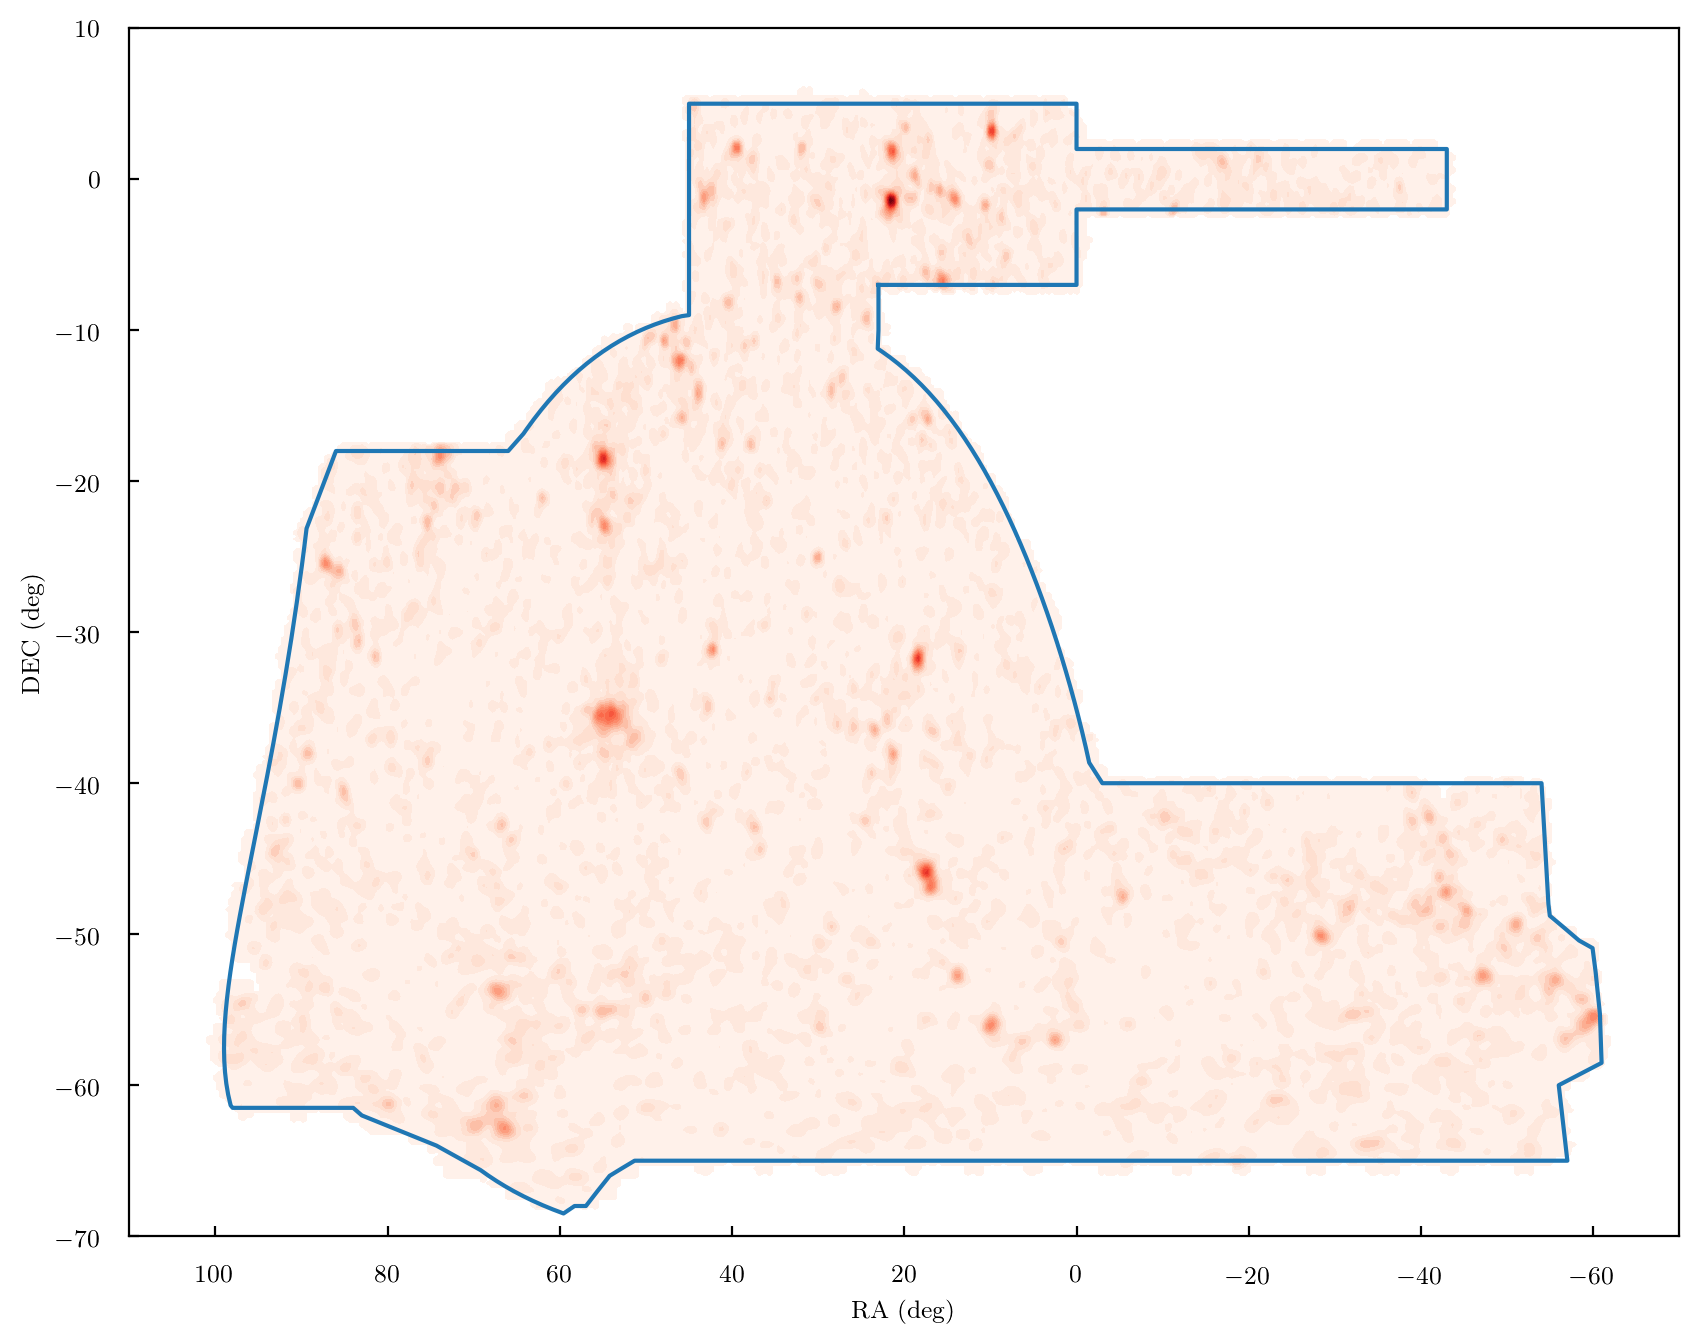

In [11]:
plt.figure(figsize = (10.0,8.0))



levels = np.linspace(1e-7, Z.max(),20)
plt.plot(ra_DES, dec_DES)
plt.contourf(X,Y,Z, levels=levels, cmap='Reds')


plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)');plt.ylabel('DEC (deg)')
plt.show()

In [12]:
print(Z.mean());print(Z.max())

0.29990149755891554
12.829135534746683


In [13]:
print(Z.max()/20)

0.6414567767373341


### Get positions of maxima

In [14]:
from skimage.feature import peak_local_max
xy = peak_local_max(Z, min_distance=1,threshold_abs=1.5)
print(np.shape(xy)[0])

420


In [15]:
ra_s_like = xy[:,1];dec_s_like = xy[:,0]

In [16]:
ra_max = x_grid[ra_s_like];dec_max = y_grid[dec_s_like]

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:946: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


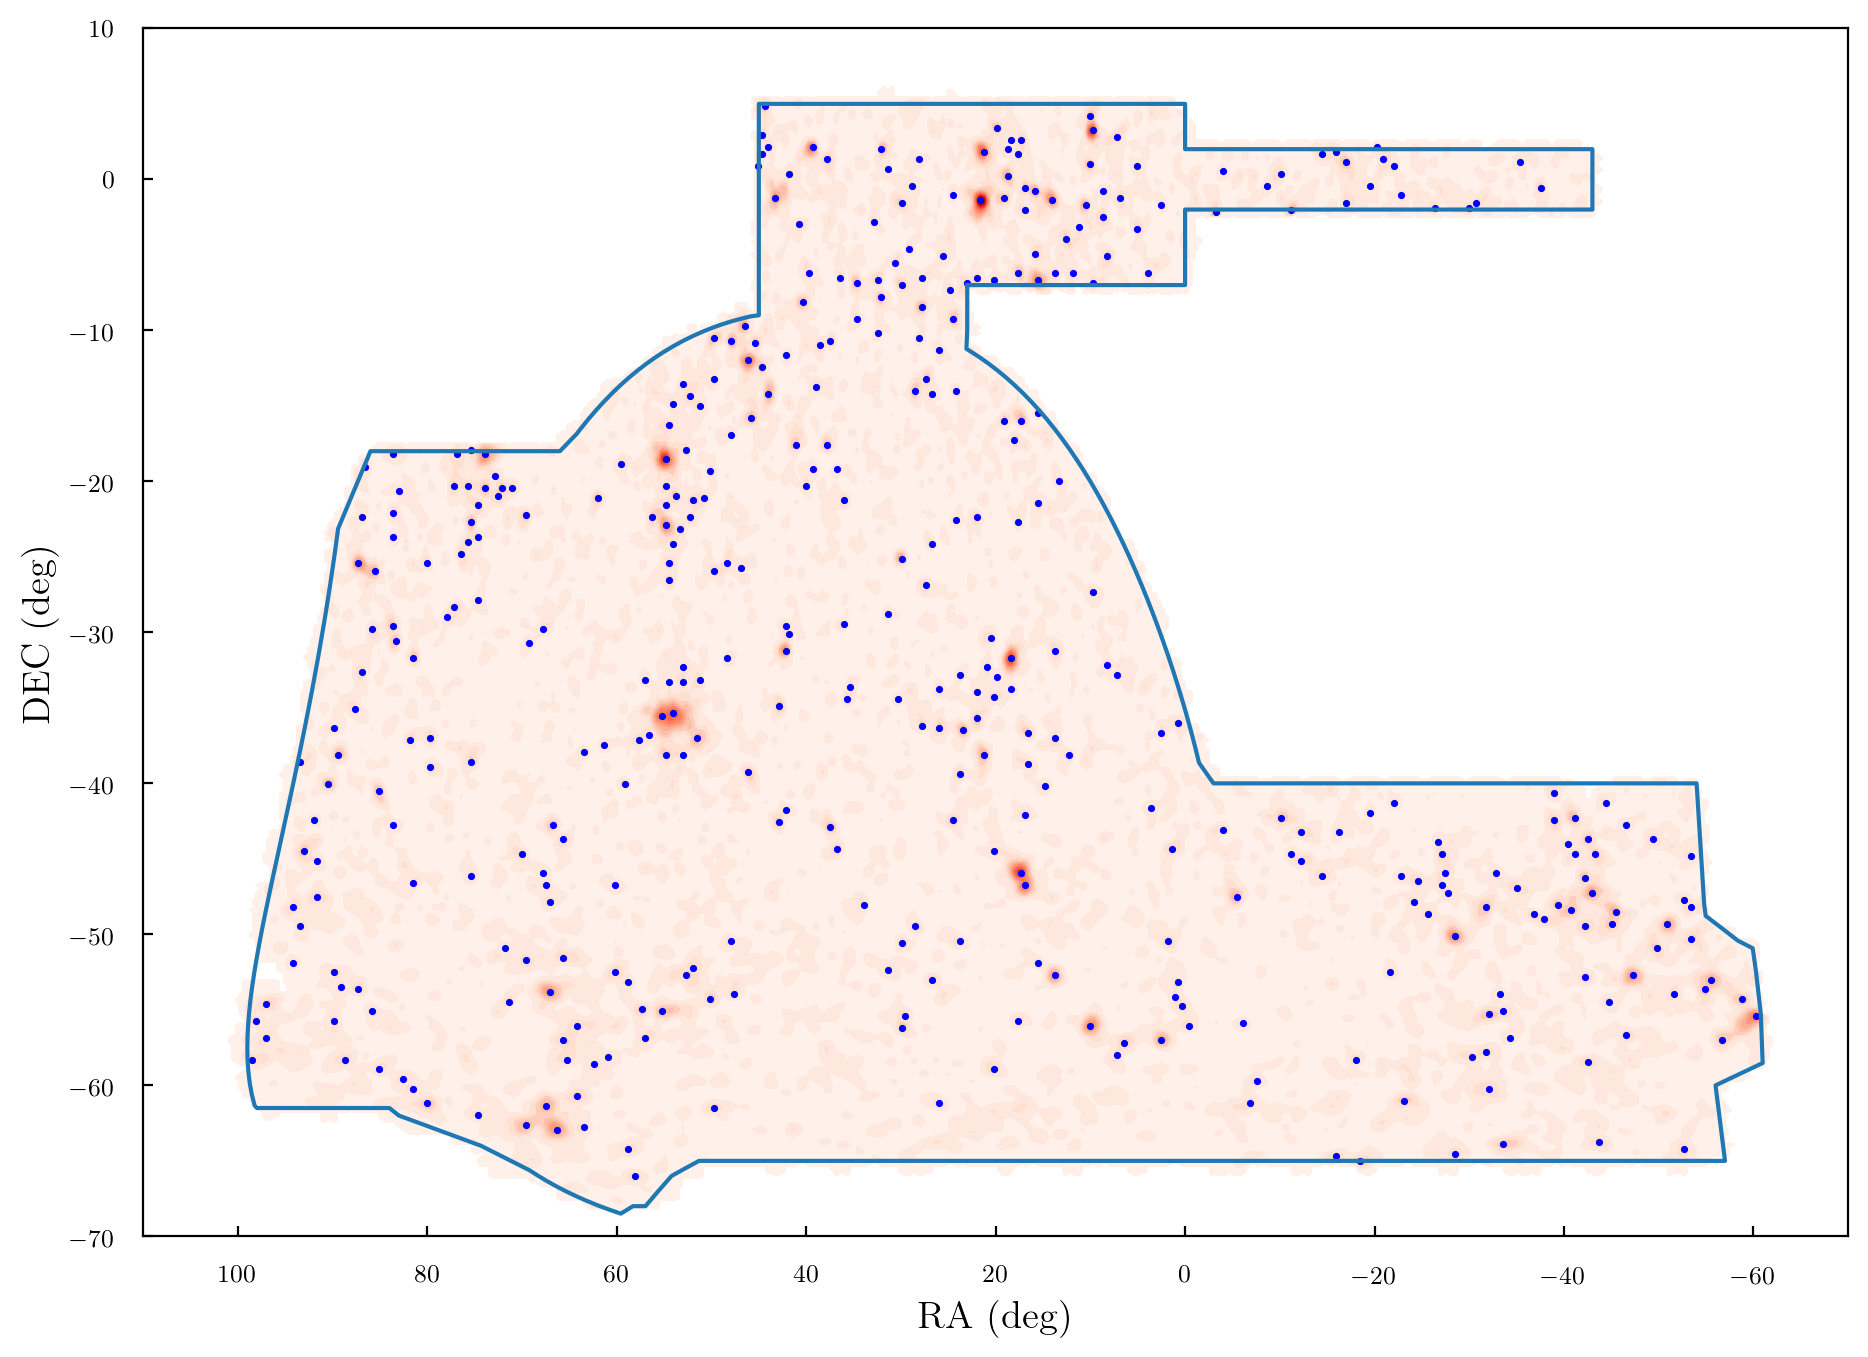

In [17]:
plt.figure(figsize = (11.0,8.0))


levels = np.linspace(1e-7, Z.max(),20)
plt.plot(ra_DES, dec_DES)
plt.contourf(X,Y,Z, levels=levels,linewidths=0.5, cmap='Reds')
plt.scatter(ra_max, dec_max, c='b', s=2.5)


plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)',fontsize=14);plt.ylabel('DEC (deg)', fontsize=14)
plt.show()

In [18]:
print(np.mean(Z[Z>0]))

0.6115396643561544


### Matching the peaks with the Abell cluster catalog and the NGC

I want to find all the clusters from the Abell cluster catalog that are within a given angular distance from each one of the above maxima.

In [23]:
# Open and read the Abell catalog
Abell_cat = fits.open('Abell.fits')
# =============================================
# =============================================
# Open and read the NGC catalog
NGC_cat = fits.open('NGC_2.fit')

In [24]:
name_Abell = Abell_cat[1].data['NAME']
ra_Abell = Abell_cat[1].data['RA']
dec_Abell = Abell_cat[1].data['DEC']
z_Abell = Abell_cat[1].data['REDSHIFT']

ra_Abell = ra_Abell[z_Abell<0.2]
dec_Abell = dec_Abell[z_Abell<0.2]
name_Abell = name_Abell[z_Abell<0.2]
z_Abell = z_Abell[z_Abell<0.2]
# ================================================
# ================================================
ra_NGC = NGC_cat[1].data['_RAJ2000']
dec_NGC = NGC_cat[1].data['_DEJ2000']
type_NGC = NGC_cat[1].data['Type']
ra_NGC = ra_NGC[type_NGC==5]
dec_NGC = dec_NGC[type_NGC==5]
# ================================================
# ================================================
for i in range(len(ra_Abell)):
    if (ra_Abell[i] > 180.):
        ra_Abell[i] = ra_Abell[i]-360.
        
for i in range(len(ra_NGC)):
    if (ra_NGC[i] > 180.):
        ra_NGC[i] = ra_NGC[i]-360.

In [25]:
# Create an object for the positions of maxima and one for the positions of the Abell and NGC clusters
C_Maxima = SkyCoord(ra=ra_max*u.degree, dec=dec_max*u.degree, frame='icrs')
C_Abell = SkyCoord(ra=ra_Abell*u.degree, dec=dec_Abell*u.degree, frame='icrs')
C_NGC = SkyCoord(ra=ra_NGC*u.degree, dec=dec_NGC*u.degree, frame='icrs')

In [26]:
n = len(ra_max)
max_sep = 1.0 # Maximum allowed angular separation (in degrees)
# ==========================================================
# ==========================================================
ra_prox = []
dec_prox = []
name_prox = []
# =================================
# =================================
ra_prox_NGC = []
dec_prox_NGC = []
# ==========================================================
# ==========================================================
for i in range(n):
    ra_loc = ra_max[i]
    dec_loc = dec_max[i]
    
    # Define an object for the position of the i-th maximum 
    C_loc = SkyCoord(ra=ra_loc*u.degree, dec=dec_loc*u.degree, frame='icrs')
    
    # Get the separation between this maximum and the objects in the Abell catalog
    sep = C_Abell.separation(C_loc).deg
    
    # Now keep objects that are within the separation limit
    ra_within = ra_Abell[sep<max_sep]
    dec_within = dec_Abell[sep<max_sep]
    name_within = name_Abell[sep<max_sep]
    
    
    ra_prox = np.concatenate((ra_prox, ra_within))
    dec_prox = np.concatenate((dec_prox, dec_within))
    name_prox = np.concatenate((name_prox, name_within))
    # ==========================================================
    # ==========================================================
    # Get the separation between this maximum and the objects in the NGC catalog
    sep_NGC = C_NGC.separation(C_loc).deg
    
    # Now keep objects that are within the separation limit
    ra_within_NGC = ra_NGC[sep_NGC<max_sep]
    dec_within_NGC = dec_NGC[sep_NGC<max_sep]
    
    ra_prox_NGC = np.concatenate((ra_prox_NGC, ra_within_NGC))
    dec_prox_NGC = np.concatenate((dec_prox_NGC, dec_within_NGC))

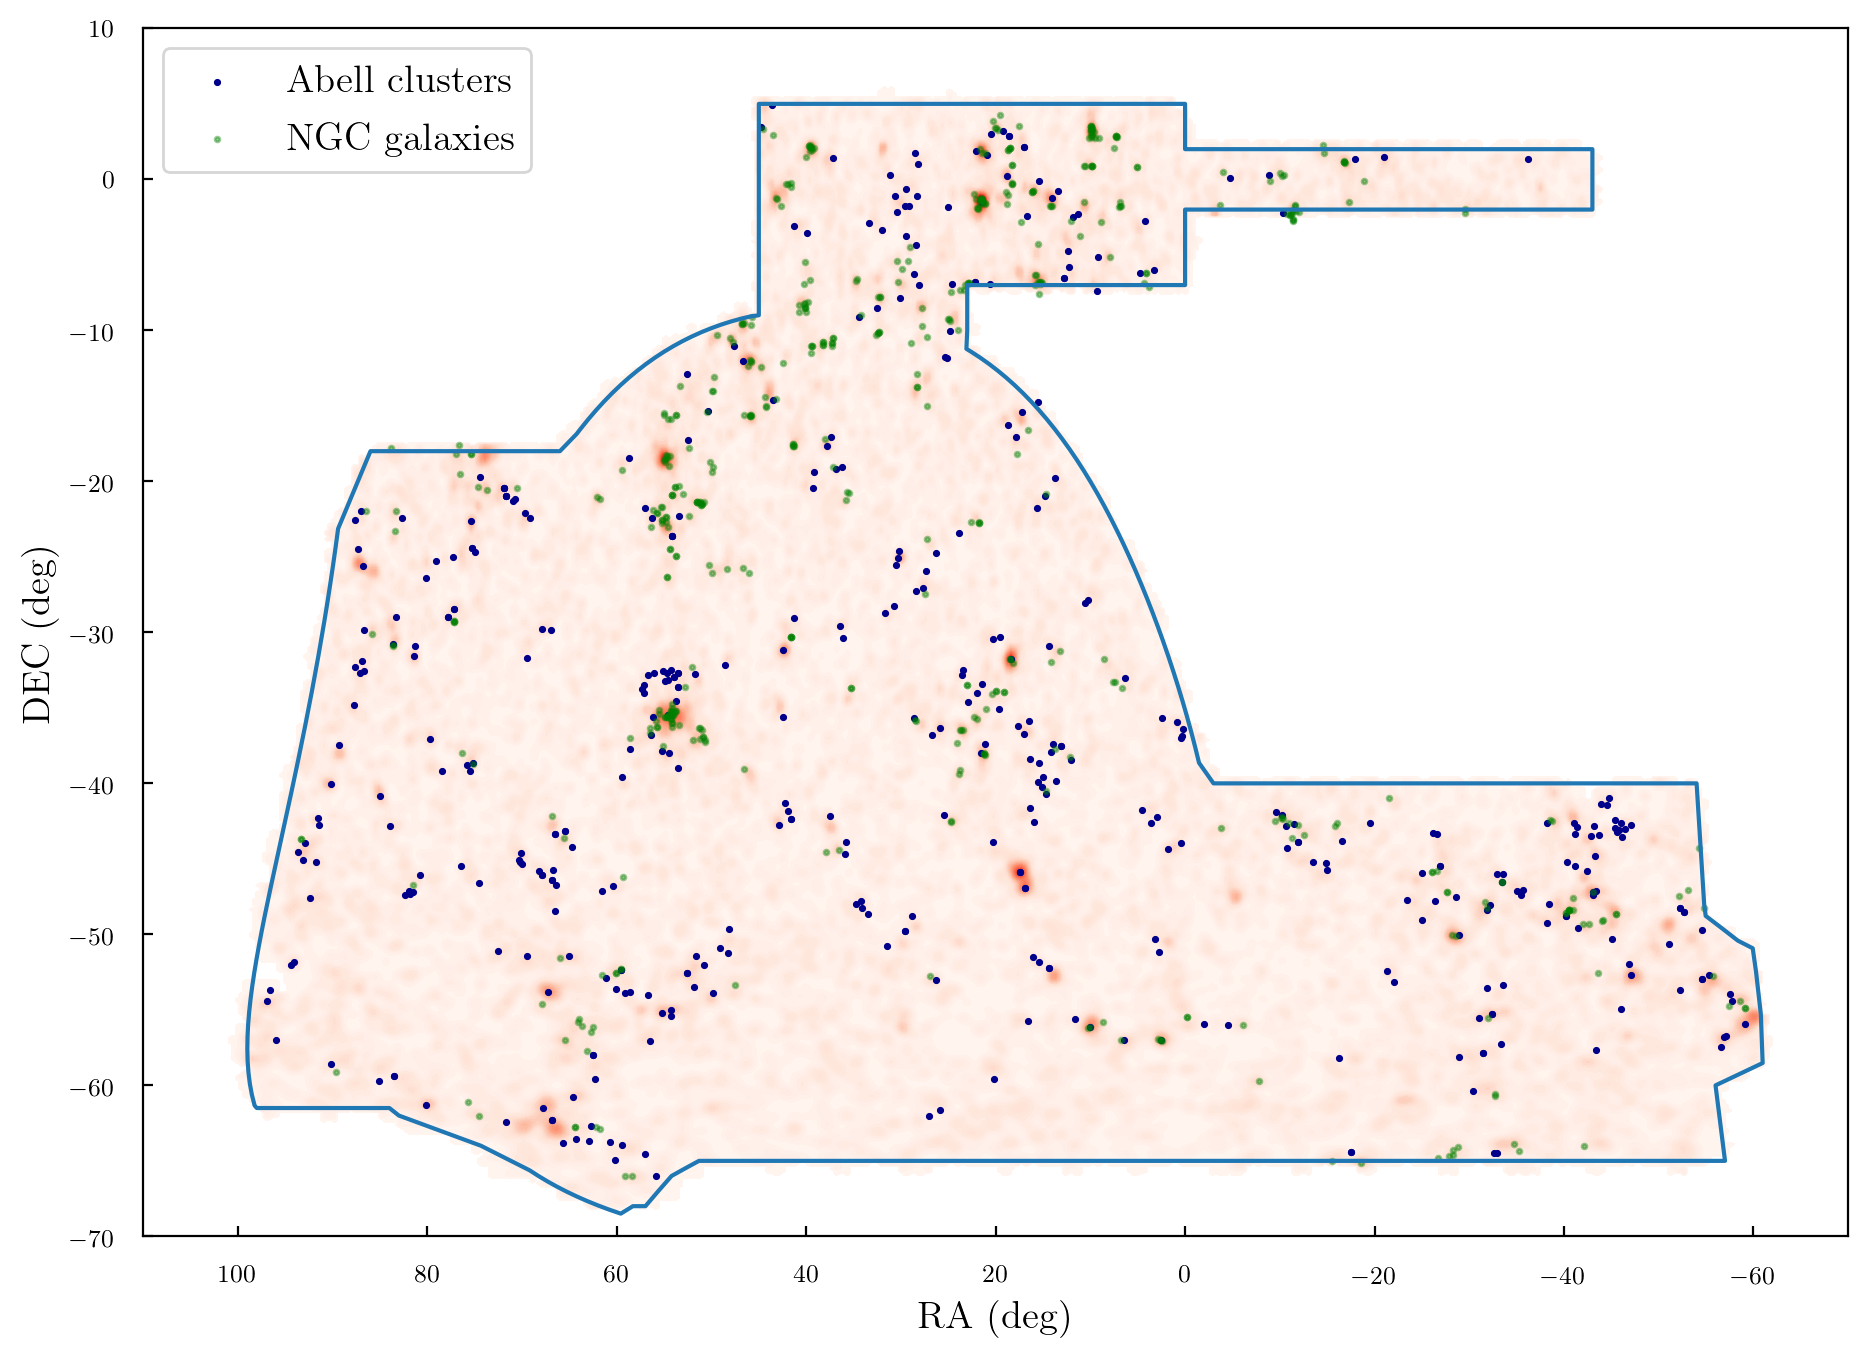

In [27]:
plt.figure(figsize = (11.0,8.0))


levels = np.linspace(1e-7, Z.max(),60)
plt.plot(ra_DES, dec_DES)
plt.contourf(X,Y,Z, levels=levels,linewidths=0.5, cmap='Reds')
plt.scatter(ra_prox, dec_prox, c='darkblue', s=2.5, label='Abell clusters')
plt.scatter(ra_prox_NGC, dec_prox_NGC, c='g', s=3.0, alpha=0.4, label='NGC galaxies')
#plt.scatter(ra_max, dec_max, c='k', s=2.5)

plt.xlim(110,-70);plt.ylim(-70,10)
plt.xlabel('RA (deg)',fontsize=14);plt.ylabel('DEC (deg)', fontsize=14)
plt.legend(frameon=True, loc='upper left', fontsize=14)
plt.show()

In [28]:
print(max(ra_NGC))

179.8953
